# DATA620 Project 1
## Does Centrality Inform us of the Bowl Eligibility of FBS Teams?
### Erik Nylander

### Introduction
In this project we ask if the centrality of team has any impact on a NCAA Division I Football Bowl Subdivision (FBS) teams bowl eligibility. To answer this question I have identified a rather interesting data set that contains the full 2010 FBS results. Each row of the data set contains the date of the game, the two teams that played and each team's score. The original data set also contains the location of the game if it was played at a neutral site. This data set was put together by James Howell and can be found on his website at http://homepages.cae.wisc.edu/~dwilson/rsfc/history/howell/cf2010gms.txt. 

Unfortunately the original data set was well formated for human readability but was mostly useless for the machine reading. To facillitate using the data I did some basica data cleaning and posted the data on my own GitHub site which can be found at https://github.com/eriknylander99/DATA620/blob/master/data/cf2010gms-clean.txt. This dataset is in comma separated format and contains a header on the third line with the first two lines being the authors attribution. 

The code below imports the 2010 FBS season data and begins the construction of a new data set that we have called record. This data set contains all of the teams that played in the 2010 season along with their wins, losses, winning percentage, bowl eligibility, and the columns for the various centrality measures. Before we move on let's discuss what makes a team bowl eligible. A FBS team is eligible to play in a postseason 'bowl game' if they have compiled a winning percentage of at least 50% or if they are from a large conference and win their conference championship game. For this analysis we will be using the first criterion as there has yet to be a team that made it to their conference championship game without winning at least half of their games. There is also an odd edge case that we are not including in this analysis. A team may become bowl eligible with a win loss record of less than 50% if there are not enough teams with a winning percentage above 50% to fill all of the games. This does happen occasionally but it does not happen in this data set.

In [1]:
# Loading the packages needed for this project
%matplotlib inline
import networkx as nx
import pandas as pd
from scipy import stats
import matplotlib
matplotlib.style.use('ggplot')
from __future__ import division

### Loading the Data
The data set contains the entire seasons including the bowl games that are played at the end of the season. We start by subsetting our data to only include games that are played before the end of the regular season on December 11th with the Army - Navy game.

In [2]:
# Reading the data into a pandas data frame
season = pd.read_csv('https://raw.githubusercontent.com/eriknylander99/DATA620/master/data/cf2010gms-clean.txt', header = 2)

# Convert the Date columns to actual date format
season['Date'] = pd.to_datetime(season['Date'], infer_datetime_format=True)

In [3]:
# Quick look at the data
season.head()

,Date,Team1,Team1_Score,Team2,Team2_Score
0,2010-09-02,Eastern Washington,24,Nevada,49
1,2010-09-02,Florida A&M,0,Miami (Florida),45
2,2010-09-02,Florida Atlantic,32,Alabama-Birmingham,31
3,2010-09-02,Hampton,0,Central Michigan,33
4,2010-09-02,Marshall,7,Ohio State,45


In [4]:
# Generating the data frame for the regular season games.(Regular season ends with the Army-Navy on 12/11/2010)
reg_season = season[season.Date <= '2010-12-11']
reg_season.tail()

,Date,Team1,Team1_Score,Team2,Team2_Score
768,2010-12-04,Troy,44,Florida Atlantic,7
769,2010-12-04,Utah State,14,Boise State,50
770,2010-12-04,Virginia Tech,44,Florida State,33
771,2010-12-04,Washington,35,Washington State,28
772,2010-12-11,Navy,31,Army,17


### Building the Record Data
Now that we have our FBS regular season results we can start building our data set that stores our list of teams (Team), their wins (Wins), losses (Loss), games played (Played), win percentage (WLP), bowl eligibility (Bowl_Eligible), degree centrality (degcen), eigenvector centrality (eigencen), closeness centrality (closecen), and betweenness centrality (betweencen). 

In [5]:
# Generating a list of all of the teams in both lists.
team1_list = set(reg_season.Team1.unique())
team2_list = set(reg_season.Team2.unique())
len(team1_list) # Number of unique teams in the Team1 column

195

In [6]:
# Joining the two columns to get a unique list of all teams in the data set
teams = list(team1_list.union(team2_list))
len(teams) # It appears that the Team1 column contains all of the teams in the data set.

195

In [7]:
# Generating a data frame to contain the wins and losses for each team
teams.sort()
record = pd.DataFrame({'Team':teams})
record['Win'] = 0
record['Loss'] = 0
record['Played'] = 0
record['WLP'] = 0
record['Bowl_Eligible'] = 'No' #Setting all teams to ineligible
record['degcen'] = 0
record['eigencen'] = 0
record['closecen'] = 0
record['betweencen'] = 0
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,Air Force,0,0,0,0,No,0,0,0,0
1,Akron,0,0,0,0,No,0,0,0,0
2,Alabama,0,0,0,0,No,0,0,0,0
3,Alabama-Birmingham,0,0,0,0,No,0,0,0,0
4,Alcorn State,0,0,0,0,No,0,0,0,0


The code below parses the 772 regular season games and fills in the record data frame for the 195 teams that are in data set. Around 60 of the teams in this data set are from the lower NCAA Football Championship Subdivision (FCS). These FCS teams will be removed before we do our final analysis given that they are ineligible to play in a bowl game but they do count towards an FBS teams win-loss record so they will not be removed until the end.

In [8]:
# Building the Wins and Loses Columns along with the total number of games played.
for index, row in reg_season.iterrows():
    if row['Team1_Score'] > row['Team2_Score']:
        record.loc[record['Team'] == row['Team1'], 'Win'] = record.loc[record['Team'] == row['Team1'], 'Win'] + 1
        record.loc[record['Team'] == row['Team1'], 'Played'] = record.loc[record['Team'] == row['Team1'], 'Played'] + 1
        record.loc[record['Team'] == row['Team2'], 'Loss'] = record.loc[record['Team'] == row['Team2'], 'Loss'] + 1
        record.loc[record['Team'] == row['Team2'], 'Played'] = record.loc[record['Team'] == row['Team2'], 'Played'] + 1
    if row['Team1_Score'] < row['Team2_Score']:
        record.loc[record['Team'] == row['Team1'], 'Loss'] = record.loc[record['Team'] == row['Team1'], 'Loss'] + 1
        record.loc[record['Team'] == row['Team1'], 'Played'] = record.loc[record['Team'] == row['Team1'], 'Played'] + 1
        record.loc[record['Team'] == row['Team2'], 'Win'] = record.loc[record['Team'] == row['Team2'], 'Win'] + 1
        record.loc[record['Team'] == row['Team2'], 'Played'] = record.loc[record['Team'] == row['Team2'], 'Played'] + 1

# Generating the winning percentage or each team.
record['WLP'] = record['Win']/record['Played']

# Calculating bowl eligibility for each team.
for index, row in record.iterrows():
    if row['WLP'] >= 0.5:
        record.loc[record['Team'] == row['Team'], 'Bowl_Eligible'] = 'Yes'

In [9]:
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,Air Force,8,4,12,0.666667,Yes,0,0,0,0
1,Akron,1,11,12,0.083333,No,0,0,0,0
2,Alabama,9,3,12,0.750000,Yes,0,0,0,0
3,Alabama-Birmingham,4,8,12,0.333333,No,0,0,0,0
4,Alcorn State,0,1,1,0.000000,No,0,0,0,0


### Generating the Graph
Now that we have built our data set containing each team's record we now need to construct our graph so that we can compute the different measures of centrality and add those two our data set. When we began this analysis we were unsure of what if any results we would find in the data. We picked this data set to see if there might be any effect on a team's likelihood of becoming bowl eligible based on their connections with other teams. We did think that there might be connection with the teams with high betweenness centrality and bowl eligibility although we are unsure of the direction of the connection. Teams that tend to play a lot of out of conference games and have a higher betweenness centrality may either do this because they are high profile teams that tend to make the playoffs or they are teams that are scheduled because they are considered to be relatively easy wins and don't tend to make the playoffs.

In [12]:
# Generating a network x from the edge list stored in pandas.
G = nx.from_pandas_dataframe(reg_season, 'Team1', 'Team2')

In [13]:
# Calculating the number of teams
nx.number_of_nodes(G)

195

In [14]:
# Calculating the number of games played.
nx.number_of_edges(G)

772

Now that we have our graph we can add our attributes to the nodes. We are adding the bowl eligibility and a color based on the bowl eligibility.

In [15]:
# Adding the Bowl Eligibility attribute to each of the nodes.
for n in G.nodes_iter():
    G.node[n]['Bowl_Eligible'] = 'No'
    G.node[n]['vis'] = {'color': {'r': 255, 'g': 0, 'b': 0, 'a': 0}}
for index, row in record.iterrows():
    G.node[row['Team']]['Bowl_Eligible'] = row['Bowl_Eligible']
    if row['Bowl_Eligible'] == 'Yes':
        G.node[row['Team']]['vis'] = {'color': {'r': 0, 'g': 0, 'b': 255, 'a': 0}}

Now that we have created our graph we can calculate the various centrality measures for each of the nodes as described above. We do note that the degree centrality is simply the number of games that each team played and therefore we don't expect to see much difference between bowl eligibility based off of this measure. Given this we have elected to calculate a number of other centrality measures as well to discover if any of them have a significant impact on the bowl eligibility.

In [16]:
# Calculating the degree of each of the teams and storing this in our record data frame
# This will be the same as the number of games played
deg = nx.degree(G) 
eig = nx.eigenvector_centrality(G)
clo = nx.closeness_centrality(G)
btw = nx.betweenness_centrality(G)
for index, row in record.iterrows():
    record.loc[record['Team'] == row['Team'], 'degcen'] = deg[row['Team']]
    record.loc[record['Team'] == row['Team'], 'eigencen'] = eig[row['Team']]
    record.loc[record['Team'] == row['Team'], 'closecen'] = clo[row['Team']]
    record.loc[record['Team'] == row['Team'], 'betweencen'] = btw[row['Team']]

In [19]:
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,Air Force,8,4,12,0.666667,Yes,12,0.098625,0.347670,0.016706
1,Akron,1,11,12,0.083333,No,12,0.080959,0.361940,0.026585
2,Alabama,9,3,12,0.750000,Yes,12,0.079146,0.369524,0.031872
3,Alabama-Birmingham,4,8,12,0.333333,No,12,0.099143,0.354662,0.007838
4,Alcorn State,0,1,1,0.000000,No,1,0.007101,0.256954,0.000000


Now that we have constructed our full data set we can trim this down to just the teams that have played more than 9 games. This ensures that we get only the FBS teams for our final analysis.

In [17]:
# Removing all of the teams that played less than a full season
FBS = record.loc[record['Played'] >= 9]
FBS.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,Air Force,8,4,12,0.666667,Yes,12,0.098625,0.347670,0.016706
1,Akron,1,11,12,0.083333,No,12,0.080959,0.361940,0.026585
2,Alabama,9,3,12,0.750000,Yes,12,0.079146,0.369524,0.031872
3,Alabama-Birmingham,4,8,12,0.333333,No,12,0.099143,0.354662,0.007838
6,Arizona,7,5,12,0.583333,Yes,12,0.088999,0.348294,0.021175


### Testing for Differences in Centrality based on Bowl Eligibility
Now that we found our centrality measures for the various teams we can construct a T-test to determine if there is a difference between the average centrality score for bowl eligible teams or if they are the same. We will also construct histograms for each of the to see if there are any interesting or unusual patterns in the data.

#### Degree Centrality
$H_0 :$ There is no difference in the average degree centrality for bowl eligible teams vs teams that are not bowl eligible.

$H_A :$ There is a difference in the degree centrality.

From our T-test we find a test statistic of 1.38 and an p-value of 0.169. Therefore we fail to reject the null hypothesis and conclude that there is no difference in degree centrality between the two groups.

Ttest_indResult(statistic=1.3837024315977424, pvalue=0.16906151050227516)

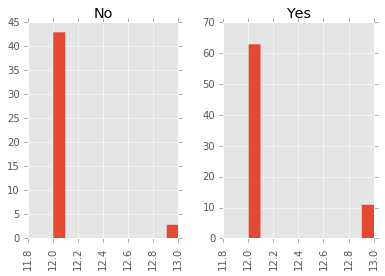

In [29]:
# Testing for differences in degree centrality based on bowl elligibility
FBS['degcen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'degcen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'degcen']) # No significant Difference

#### Eigenvector Centrality
$H_0 :$ There is no difference in the average eigenvector centrality for bowl eligible teams vs teams that are not bowl eligible.

$H_A :$ There is a difference in the eigenvector centrality.

From our T-test we find a test statistic of -1.782 and an p-value of 0.0772. Therefore we fail to reject the null hypothesis and conclude that there is no difference in eigenvector centrality between the two groups. However we do also note that at an $\alpha$ level of .1 we would have a significant difference. This may be an interesting result to further explore in other years data. 

Ttest_indResult(statistic=-1.7824513546991834, pvalue=0.077247291509196223)

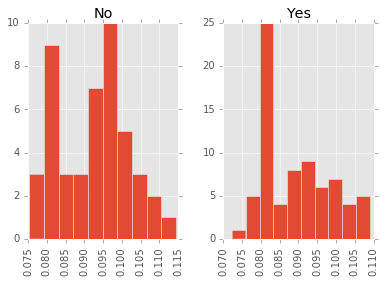

In [22]:
# Testing for differences in eigenvalue centrality based on bowl eligibility
FBS['eigencen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'eigencen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'eigencen']) # No significant Difference

#### Closness Centrality

$H_0 :$  There is no difference in the average closness centrality for bowl eligible teams vs teams that are not bowl eligible.

$H_A :$ There is a difference in the closness centrality.

From our T-test we find a test statistic of 0.931 and an p-value of 0.354. Therefore we fail to reject the null hypothesis and conclude that there is no difference in closness centrality between the two groups.

Ttest_indResult(statistic=0.93121191466252662, pvalue=0.35364525274230718)

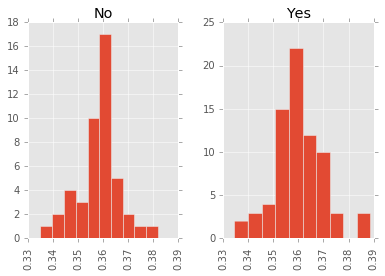

In [23]:
# Testing for differences in closness centrality based on bowl eligibility
FBS['closecen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'closecen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'closecen']) # No significant Difference

#### Betweenness Centrality

$H_0 :$  There is no difference in the average betweenness centrality for bowl eligible teams vs teams that are not bowl eligible.

$H_A :$ There is a difference in the betweenness centrality.

From our T-test we find a test statistic of 2.967 and an p-value of 0.00364. Therefore we reject the null hypothesis and conclude that there is a difference in betweenness centrality between the two groups. We also can see from our histograms that teams with higher betweenness ratings are mor likely to make a bowl game.

Ttest_indResult(statistic=2.9671291823356158, pvalue=0.0036399740301946348)

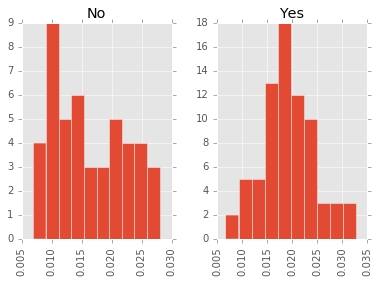

In [24]:
# Testing for differences in betweenness centrality based on bowl eligibility
FBS['betweencen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'betweencen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'betweencen']) # Significant Difference at alpha = 0.05

### Drawing the Graph

We finish up our analysis of the FBS data by constructing the graph for the regular season. We start off by trimming the teams away that do not play enough games in the season. This once again limits our graph to just the FBS teams. We start by constructing the graph in networkX but we can see that networkX lacks the ability to draw the graph in an easy to see format so we will also construct the graph in Gephi and import the image.

In [18]:
# Function to trim the edges for non-FBS teams
def trim_degrees(g, degree = 1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g2.nodes():
        if d[n] <= degree:
            g2.remove_node(n)
    return g2

In [19]:
core = trim_degrees(G, degree = 3)

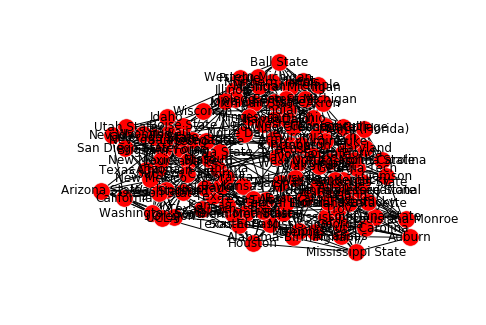

In [20]:
nx.draw(core, with_labels=True)

In [21]:
# Writing the graph as a GEXF file.
nx.write_gexf(core, 'd:/data/data620/FBS.gexf')

Gephi Graph below. The Nodes in red are teams that are Bowl Eligible and the nodes in green were no bowl eligible. We can see from the graph that conference also has an impact in bowl eligibility. The conferences on the left side of the graph also tend to play more games with teams outside of their conferences. The three teams in the middle of the graph are independents.

![Image of the Gephi Graph](https://github.com/eriknylander99/DATA620/tree/master/Images "2010 FBS Graph")

 ### Conclusions
When we started this project we had no real expectations about what we would be able to find in the data set. It was simply an interesting data set that about football, which I love. Ultimately we were able to find some interesting information, specifically that the betweenness centrality measure is a statistically significant predictor of a team's bowl eligibility. The value of the test statistic and the histograms lead us to believe that a team with a higher betweenness centrality has a higher chance to be bowl eligible. This implies that teams who serve as bridges between the different clusters, or FBS conferences, are more likely to be bowl eligible. This is an interesting and unexpected finding and warrants further study looking to see if this holds for other years. We also found that the eigenvector centrality also may have an impact on the bowl eligibility of teams. This is an interesting factor since no nodes are really any more central than others. However any team that played in a conference championship game had a 13 game season and we see that a number of bowl eligible teams came out of conferences that have a conference championship. This is another topic that would interesting for further study.